In [2]:
import gymnasium as gym
import time
import pygame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

# from algorithms.rl import RL
# from examples.test_env import TestEnv
from algorithms.planner import Planner

In [3]:
T,R = mdptoolbox.example.forest(S=400)

In [4]:
colors = {0: 'red', 1: 'green'}

labels = {
    0: 'W',
    1: 'C',
}


def plot_forest(policy, title='Forest Management'):
    rows = 20
    cols = 20

    policy = np.array(list(policy)).reshape(rows, cols)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, xlim=(-0.01, cols + 0.01), ylim=(-0.01, rows + 0.01))
    plt.title(title)

    for i in range(20):
        for j in range(20):
            y = 20 - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[policy[i, j]])
            ax.add_patch(p)

            text = ax.text(
                x + 0.5,
                y + 0.5,
                labels[policy[i, j]],
                horizontalalignment='center',
                size=10,
                verticalalignment='center',
                color='w',
            )

    plt.axis('off')

In [9]:
def valueIteration(t, r, gammas, epsilons, showResults=False, max_iterations=10000):
    start_time = time.time()
    
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)

    
    testNum = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, epsilon=e, max_iter=max_iterations)
            
            runs  = test.run()
            Time  = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR  = runs[-1]['Max V']
            
            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])
            
            policy = np.array(test.policy)
            
            data['gamma'][testNum]        = g
            data['epsilon'][testNum]      = e
            data['time'][testNum]         = Time
            data['iterations'][testNum]   = iters
            data['reward'][testNum]       = maxR
            data['mean_rewards'][testNum] = {tuple(mean_rewards)}
            data['max_rewards'][testNum]  = {tuple(max_rewards)}
            data['error'][testNum]        = {tuple(errors)}
            data['policy'][testNum]       = {test.policy}
                        
            testNum += 1
        
    print('Time taken: ' + str(time.time() - start_time))
    
    # # See differences in policy
    # policies = data['policy']
    
    # replace all NaN's
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [10]:
gammas   = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
epsilons = [1e-2, 1e-3, 1e-8, 1e-12]
vi_data  = valueIteration(T, R, gammas, epsilons, showResults=False)

C:\Users\trevo\AppData\Local\Temp\ipykernel_42664\2235283675.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{(1.005, 1.0061250000000002)}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data['mean_rewards'][testNum] = {tuple(mean_rewards)}
C:\Users\trevo\AppData\Local\Temp\ipykernel_42664\2235283675.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['max_rewards'][testNum]  = {tuple(max_rewards)}
C:\Users\trevo\AppData\Local\Temp\ipykernel_42664\2235283675.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{(4.0, 4.36)}' has dtype incompatible with float64, please explicitly cast to a compatible dtype f

Time taken: 0.5292000770568848


C:\Users\trevo\AppData\Local\Temp\ipykernel_42664\2235283675.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gamma'][testNum]        = g
C:\Users\trevo\AppData\Local\Temp\ipykernel_42664\2235283675.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['epsilon'][testNum]      = e
C:\Users\trevo\AppData\Local\Temp\ipykernel_42664\2235283675.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time'][testNum]        

<Axes: title={'center': 'FM PI Reward vs. Iterations'}, xlabel='reward'>

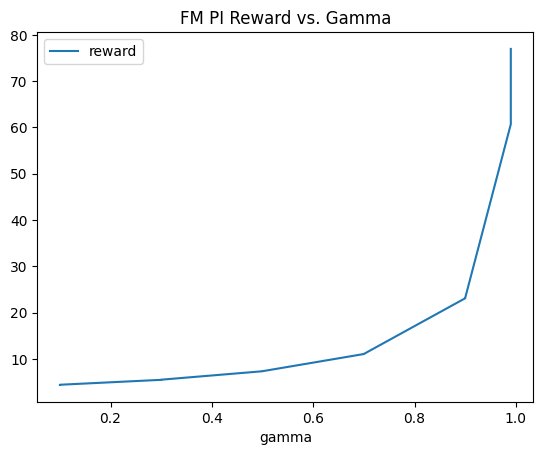

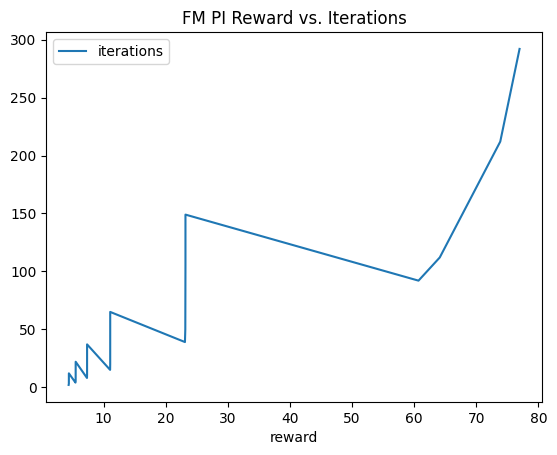

In [13]:

vi_data.plot(x='gamma', y='reward', title="FM PI Reward vs. Gamma")
vi_data.plot(x='reward', y='iterations', title="FM PI Reward vs. Iterations")


In [14]:
# find the highest score
bestRun = vi_data['reward'].argmax()
bestPolicy = vi_data['policy'][bestRun]
print('best Reward = ' + str(vi_data['reward'].max()))
print('best Gamma = ' + str(vi_data['gamma'].max()))
print('best Epsilon = ' + str(vi_data['epsilon'].max()))


best Reward = 76.97495085837569
best Gamma = 0.99
best Epsilon = 0.01


Policy Iteration

In [64]:
def policyIteration(t, r, gammas, showResults=False, max_iterations=100000):
    t0 = time.time()
    
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)), columns=columns)
    
    print('gamma,\ttime,\titer,\treward')
    print(80*'_')
    
    testnum = 0
    for g in gammas:
        test = PolicyIteration(t, r, gamma=g, max_iter=max_iterations, eval_type="matrix") # eval_type="iterative"
        
        runs  = test.run()
        Time  = test.time
        iters = test.iter
        maxr  = runs[-1]['Max V']
                
        max_rewards, mean_rewards, errors = [], [], []
        for run in runs:
            max_rewards.append(run['Max V'])
            mean_rewards.append(run['Mean V'])
            errors.append(run['Error'])
        
        data['gamma'][testnum]        = g
        data['time'][testnum]         = Time
        data['iterations'][testnum]   = iters
        data['reward'][testnum]       = maxr
        data['mean_rewards'][testnum] = {tuple(mean_rewards)}
        data['max_rewards'][testnum]  = {tuple(max_rewards)}
        data['error'][testnum]        = {tuple(errors)}
        data['policy'][testnum]       = {test.policy}
        
        print('%.2f,\t%.2f,\t%d,\t%f' % (g, Time, iters, maxr))
        
        if showResults:
            plot_forest(policy, title)
            pass
        
        testnum = testnum + 1
        
    endTime = time.time() - t0
    print('Time taken: %.2f' % endTime)
    
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [69]:
gamma_iter   = [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]
pi_data  = policyIteration(T, R, gamma_iter, showResults=False)

gamma,	time,	iter,	reward
________________________________________________________________________________


C:\Users\trevo\AppData\Local\Temp\ipykernel_43716\542703040.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{(1.0153493295695128,)}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data['mean_rewards'][testnum] = {tuple(mean_rewards)}
C:\Users\trevo\AppData\Local\Temp\ipykernel_43716\542703040.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['max_rewards'][testnum]  = {tuple(max_rewards)}
C:\Users\trevo\AppData\Local\Temp\ipykernel_43716\542703040.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{(4.396612561750176,)}' has dtype incompatible with float64, please explicitly cast to a compatible dtype f

0.10,	0.20,	1,	4.396613
0.30,	0.03,	2,	5.491933
0.50,	0.15,	3,	7.329154


C:\Users\trevo\AppData\Local\Temp\ipykernel_43716\542703040.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gamma'][testnum]        = g
C:\Users\trevo\AppData\Local\Temp\ipykernel_43716\542703040.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time'][testnum]         = Time
C:\Users\trevo\AppData\Local\Temp\ipykernel_43716\542703040.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['iterations'][testnum]  

0.70,	0.22,	5,	11.054551


C:\Users\trevo\AppData\Local\Temp\ipykernel_43716\542703040.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gamma'][testnum]        = g
C:\Users\trevo\AppData\Local\Temp\ipykernel_43716\542703040.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time'][testnum]         = Time
C:\Users\trevo\AppData\Local\Temp\ipykernel_43716\542703040.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['iterations'][testnum]  

0.90,	0.35,	10,	23.172434
0.99,	0.40,	18,	79.492429
Time taken: 1.37


C:\Users\trevo\AppData\Local\Temp\ipykernel_43716\542703040.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gamma'][testnum]        = g
C:\Users\trevo\AppData\Local\Temp\ipykernel_43716\542703040.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time'][testnum]         = Time
C:\Users\trevo\AppData\Local\Temp\ipykernel_43716\542703040.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['iterations'][testnum]  

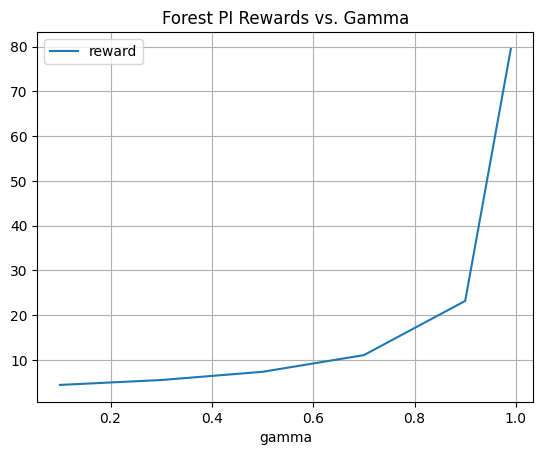

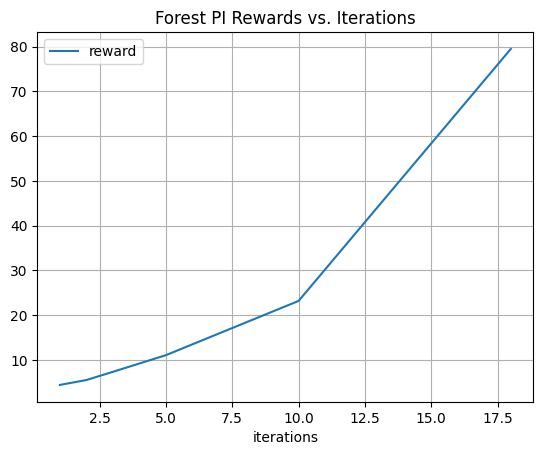

In [71]:
pi_data.plot(x='gamma', y='reward', title='Forest PI Rewards vs. Gamma')
plt.grid()

pi_data.plot(x='iterations', y='reward', title='Forest PI Rewards vs. Iterations')
plt.grid()

Q-Learning

In [15]:
def qLearning(t, r, gammas, alphas, alpha_decays=[0.99], epsilon_decays=[0.99], n_iterations=[10000000], showResults=False):
    # create data structure to save off
    columns = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'time', 'reward', 'average_steps', 'steps_stddev', 'success_pct', 'policy', 'mean_rewards', 'max_rewards', 'error']
    numTests = len(gammas)*len(alphas)*len(alpha_decays)*len(epsilon_decays)*len(n_iterations)
    data = pd.DataFrame(0.0, index=np.arange(numTests), columns=columns)

    testNum = 0
    for g in gammas:
        for a in alphas:
            for a_decay in alpha_decays:
                for e_decay in epsilon_decays:
                    for n in n_iterations:                        
                        test = QLearning(t, r, gamma=g, alpha=a, alpha_decay=a_decay, epsilon_decay=e_decay, n_iter=n)
                        
                        runs  = test.run()
                        time  = runs[-1]['Time']
                        iters = runs[-1]['Iteration']
                        maxR  = runs[-1]['Max V']
                        
                        max_rewards, mean_rewards, errors = [], [], []
                        for run in runs:
                            max_rewards.append(run['Max V'])
                            mean_rewards.append(run['Mean V'])
                            errors.append(run['Error'])
                        
                        data['gamma'][testNum]         = g
                        data['alpha'][testNum]         = a
                        data['alpha_decay'][testNum]   = a_decay
                        data['epsilon_decay'][testNum] = e_decay
                        data['time'][testNum]          = time
                        data['iterations'][testNum]    = iters
                        data['reward'][testNum]        = maxR
                        data['mean_rewards'][testNum]  = {tuple(mean_rewards)}
                        data['max_rewards'][testNum]   = {tuple(max_rewards)}
                        data['error'][testNum]         = {tuple(errors)}
                        data['policy'][testNum]        = {test.policy}

                        testNum += 1
                        
    data.fillna(0, inplace=True)
    data.head()
        
    return data

In [16]:
gammas = [0.99]
alphas = [0.01, 0.1]
alpha_decays = [0.9, 0.999]
epsilon_decays = [0.9, 0.999]
iterations = [10000, 50000]

ql_data  = qLearning(T, R, gammas, alphas, alpha_decays=alpha_decays, epsilon_decays=epsilon_decays, n_iterations=iterations, showResults=False)


C:\Users\trevo\AppData\Local\Temp\ipykernel_42664\4207881284.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '{(0.0, 2.25e-05, 2.25e-05, 2.25e-05, 2.25e-05, 2.25e-05, 2.25e-05, 2.25e-05, 2.25e-05, 2.25e-05, 2.25e-05, 2.25e-05, 2.956073841202501e-05, 2.956073841202501e-05, 2.956073841202501e-05, 2.956073841202501e-05, 2.956073841202501e-05, 2.956073841202501e-05, 2.956073841202501e-05, 2.956073841202501e-05, 2.956073841202501e-05, 2.956073841202501e-05, 2.956073841202501e-05, 2.9567728543052912e-05, 3.2060667804640885e-05, 3.2060667804640885e-05, 3.2060667804640885e-05, 3.2060667804640885e-05, 3.2060667804640885e-05, 3.2060667804640885e-05, 3.2060667804640885e-05, 3.2060667804640885e-05, 3.2060667804640885e-05, 3.2060667804640885e-05, 3.2060667804640885e-05, 3.2060667804640885e-05, 3.4560667804640885e-05, 3.4560667804640885e-05, 3.456314280464089e-05, 3.706064280464089e-05, 3.706064525489089e-05, 3.7065590304890

In [17]:
# Look at correlation matrix
interest = ['gamma', 'alpha', 'alpha_decay', 'epsilon_decay', 'iterations', 'reward', 'time']

# pick out hyperparameters and how succesful they were
df = ql_data[interest]

# See what affected the success_pct the most
ql_corr = df.corr()

def plot_QL(dependent, independent, title=None, logscale=False):
    if dependent not in interest:
        print('Dependent variable not available')
        return
    if independent not in interest:
        print('Independent variable not available')
        return
    
    x = np.unique(df[dependent])
    y = []
    
    for i in x:
        y.append(df.loc[df[dependent] == i][independent].mean())
        
    fig = plt.figure(figsize=(6,4))
    plt.plot(x, y, 'o-')
    
    if title == None:
        title = independent + ' vs. ' + dependent
    plt.title(title, fontsize=15)
    plt.xlabel(dependent)
    plt.ylabel(independent)
    plt.grid(True)
    if logscale:
        plt.xscale('log')
    
    title='QL_' + independent + '_vs_' + dependent

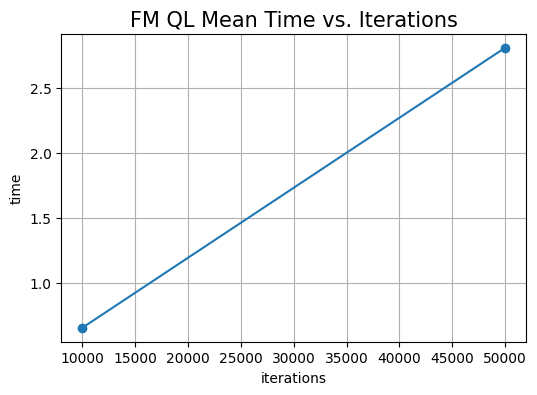

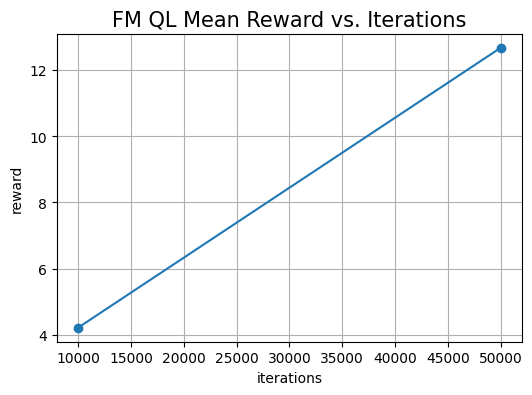

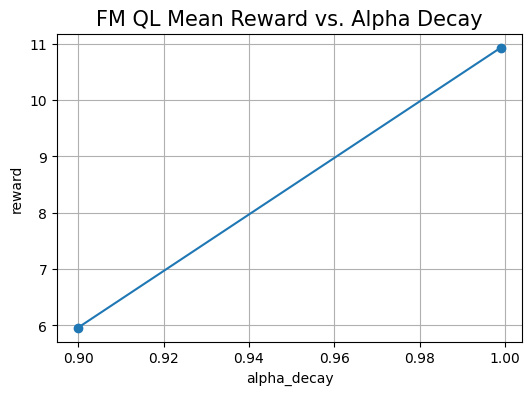

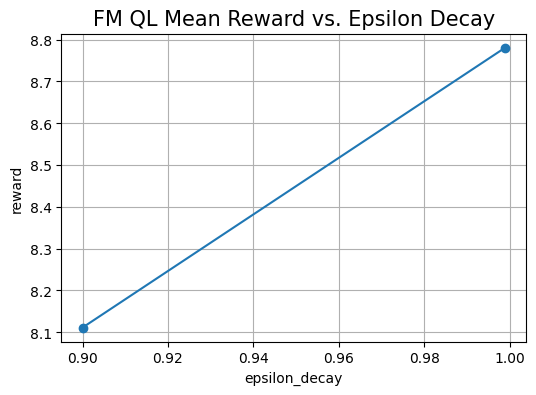

In [18]:
plot_QL('iterations', 'time', title='FM QL Mean Time vs. Iterations')
plot_QL('iterations', 'reward', title='FM QL Mean Reward vs. Iterations')
plot_QL('alpha_decay', 'reward', title='FM QL Mean Reward vs. Alpha Decay')
plot_QL('epsilon_decay', 'reward', title='FM QL Mean Reward vs. Epsilon Decay')
